# Lightweight Specifications for Distinguishing Functions

In this article we consider projects that involve the rapid implementation of two or more libraries or frameworks that are interdependent (or that must be mutually compatible). When such libraries implement a large number of primitive mathematical functions and operators (such as hash functions, cryptographic primitives, and other transformations on binary data), specifications can be useful both for unambiguous communication among team members (*i.e.*, about the identity of any given function) and for automated testing within an interactive development cycle.

This article presents an approach for implementing extremely concise (*i.e.*, no more than a few lines of code) specifications and identity confirmation unit tests for functions that operate on binary data. This approach sacrifices completeness in favor of extreme portability, concision, and ease of assembly. In particular, the following criteria are prioritized:

* deterministically replicable streams of pseudorandom input values should be possible to generate automatically from concise seed values;
* the pseudorandom input values should be straightforward to convert into a form that is compatible with function and operator signatures so that inputs need not be specified or explicitly encoded; and; and
* correct output streams corresponding to input value streams should be possible to specify using an extremely concise encoding (*i.e.*, they should fit within one line of code).

This article presents one way in which the above criteria can be satisfied by describing the open-source Python library [fountains](https://pypi.org/project/fountains), and informally analyzes this approach via an example that involves a set of with real-world functions.

## Motivation

The purpose of this work is to provide a framework that assists software engineers working in scenarios that involve (1) the implementation of a utility library that consist of many functions that have similar names, serve a similar purpose, or have similar behavior, or (2) the simultaneous implementation of multiple utility libraries that must have either identical or interoperable implementations of similar functions (*e.g.*, when porting libraries across platforms).

One domain within which such circumstances may arise is applied cryptography. When porting low-level cryptographic primitives between platforms, for example, software engineers may find it useful to specify the behavior of a function with more precision than merely its name, its type, or a reference to a formal definition or specification. As an example, consider the following two functions included within the [libsodium](https://github.com/jedisct1/libsodium) library that employ the [Ristretto](https://libsodium.gitbook.io/doc/advanced/point-arithmetic/ristretto) format for elliptic curve group elements. 

* the `crypto_scalarmult_ristretto255` function multiplies a point (the second argument, a 32-byte array) by a scalar (the third argument, a 32-byte array) and stores the result in its destination (the first argument, a 32-byte array); and
* the `crypto_core_ristretto255_scalar_mul` function multiplies a scalar (the second argument, a 32-byte array) by another scalar (the third argument, a 32-byte array) and stores the result in its destination  (the first argument, a 32-byte array).

Notice that the name, signature, and even underlying purpose of these two functions can easily lead to confusion. While a thoroughly constructed test suite would likely resolve any human errors introduced during the development process, tracking down the cause of unexpected behaviors may introduce significant delays before that point.

A lightweight way to help software engineers in such scenarios is to pair each function with a concise representation of its correct behavior that can be communicated quickly (both within code and via other channels) using about as many characters as the name of the function itself. It is important to note that the purpose of the proposed technique is to help collaborating software engineers communicate the identity of a function; the purpose is not to detect errors within the function's implementation itself or to detect malicious modifications to a function's implementation.

## Generating Specifications

Let $\{0, 1\}^{\ast}$ represent the set of all bit vectors (including the bit vector of length zero); for a bit vector $v \in \{0, 1\}^{\ast}$ let $v_i$ represent the bit at position $i$ within that bit vector. We consider functions of the form $f: \{0, 1\}^{\ast} \to \{0, 1\}^{\ast}$. A *concise partial specification* for $f$ consists of the following three components:

* a seed bit vector $s \in \{0, 1\}^{\ast}$ for generating a sequence of input bit vectors,
* a value $k \in \mathbb{N}$ representing the length of the input bit vectors to which the function is applied, and
* a reference bit vector $r \in \{0, 1\}^{\ast}$ representing information about the outputs of the function on the sequence of input vectors as determined by $s$ and $k$.

Assuming that $s$ can be a fixed length (particularly if a pseudorandom generator is used to construct input bit vectors), all except a fixed and finite portion of a specification consists of the reference bit vector.

For a fixed $k \in \mathbb{N}$, let $G_{k}: \{0, 1\}^{\ast} \times \mathbb{N} \to \{0, 1\}^{k}$ be a function that for a given seed $s \in \{0, 1\}^{\ast}$ and a given natural number $i \in \mathbb{N}$ emits a pseudorandom bit vector $G_{k}(s, i)$ of length $k$. In order to keep specifications as concise as possible, the reference bit vector $r$ for a function $f$ on some number of inputs $n$ is defined to be a vector of length $n$ of the form:

$$r = \langle f(G_{k}(s, i))_{i \ \mathrm{mod} \ |f(G_{k}(s, i))| } \ | \ i \in \{0, \ldots, n\} \rangle.$$

The above definition ensures that the representation size of $r$ is proportional to the number of inputs being considered for $f$. Note that the reference vector encodes only a *single bit* of each output (though the exact position of this bit may or may not differ between different outputs).

## Implementation

The open-source Python library [fountains](https://pypi.org/project/fountains) implements the approach described in the section above. The examples in this article rely on this package to exemplify the technique and to illustrate how it can be applied.

In [1]:
from fountains import fountains

The library uses SHA-256 to turn a seed bytes-like object into an infinite bit vector. In particular, the library make it possible to construct an iterable of pseudorandom bit vectors (all derived from that seed) of a specified length (where the length is specified in the number of bytes).

In [1]:
from bitlist import bitlist

for v in fountains(length=1, seed=bytes([0])):
    print(bitlist(v))
    break

bitlist('01101110')


A reference bit vector can be created for any function (that operates on bytes-like objects) by supplying that function via the optional `function` parameter.

In [1]:
import itertools
from hashlib import md5

ref_iterable = fountains(
    length=32,
    seed=bytes([0]),
    function=lambda v: md5(v).digest()
)
ref = list(itertools.islice(ref_iterable, 0, 8))
ref

[0, 0, 0, 0, 1, 0, 0, 0]

The library makes it possible to confirm that a function satisfies a given reference bit vector by supplying that vector via an optional `bits` argument. This yields an iterable of boolean values (one for each input-output pair represented by the bits of the reference bit vector).

In [1]:
list(fountains(
    length=32,
    seed=bytes([0]),
    function=lambda v: md5(v).digest(),
    bits=ref
))

[True, True, True, True, True, True, True, True]

Notice that a different function does not necessarily satisfy the reference bit vector.

In [1]:
from hashlib import sha512

list(fountains(
    length=32,
    seed=bytes([0]),
    function=lambda v: sha512(v).digest(),
    bits=ref
))

[True, False, True, True, True, False, True, True]

## Example

How suitable is this technique for generating concise specification for functions found in widely used libraries? The minimal length of a specification's reference bit vector will depend on the number of functions that must be distinguished. As an example, we consider the set of hash functions available in Python's built-in [hashlib](https://docs.python.org/3/library/hashlib.html) library.

In [1]:
import hashlib

functions = [
    # Default value `alg` evaluated at function
    # definition (this is necessary to avoid
    # capture by reference within the closure).
    (lambda x, alg_=alg: hashlib.new(alg_, x).digest())
    for alg in hashlib.algorithms_guaranteed
    if alg not in ['shake_256', 'shake_128']
]

The function below returns a reference bit vector of length `n` for a function `f`.

In [1]:
def reference(f, n):
    return tuple(
        itertools.islice(fountains(length=32, function=f), 0, n)
    )

The reference bit vectors below illustrate that, for a reference bit vector length of `8`, each of the `12` functions in the list `functions` has a distinct reference bit vector.

In [1]:
{reference(f, 8) for f in functions}

{(0, 0, 0, 0, 1, 1, 0, 1),
 (0, 1, 0, 0, 0, 0, 1, 0),
 (0, 1, 0, 1, 1, 0, 0, 0),
 (1, 0, 0, 0, 0, 1, 0, 1),
 (1, 0, 0, 1, 1, 1, 1, 0),
 (1, 0, 1, 1, 0, 1, 1, 1),
 (1, 0, 1, 1, 1, 1, 1, 0),
 (1, 1, 0, 0, 0, 0, 1, 0),
 (1, 1, 0, 1, 1, 0, 1, 1),
 (1, 1, 1, 0, 1, 0, 1, 0),
 (1, 1, 1, 0, 1, 1, 0, 1),
 (1, 1, 1, 1, 0, 1, 0, 1)}

It is possible to compute the minimum number of bits needed for the reference portion of a specification for different subsets of functions from the list `functions`. Auxiliary functions are defined below for computing the average and for sampling subsets of the set of hash functions.

In [1]:
import itertools
import random

def avg(xs):
    return sum(xs) / len(xs)

def subsets(functions, size, sample):
    fs = list(itertools.combinations(functions, size))
    return random.sample(
        fs,
        min(sample, len(fs))
    )

For each possible subset size `size` of the set of hash functions called `functions`, there are a number of possible subsets. We take a random sample of `16` of these using `subsets(functions, size, 16)`. For each subset `fs` in `subsets(functions, size, 16)`, we compute the minimum reference bit vector length that makes it possible to distinguish all the functions within that subset `fs`. We can than aggregate these minimum lengths (in the definition below, we compute the average of these) to get an idea of what length a reference bit vector must be to distinguish a set containing `size` distinct functions.

In [1]:
from tqdm import tqdm

lengths = {
    # Average of minima across subsets of this size.
    size: avg([
        # Minimum reference bit vector length that
        # makes it possible to distinguish all
        # functions in the subset from one another.
        min([
            k
            for k in range(1, 8)
            if len({reference(f, k) for f in fs}) == len(fs)
        ])
        for fs in subsets(functions, size, 32)
    ])

    # For each possible subset size.
    for size in tqdm(
        range(2, len(functions) + 1),
        position=0, leave=True
    )
}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.45s/it]


The results show that the average number of bits remains quite low as the number of functions that must be distinguished grows, suggesting that very concise reference strings may be sufficient even for a scenarios involving hundreds of functions.

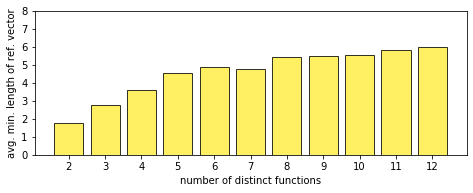

In [1]:
import matplotlib.pyplot as plt

plt.figure().add_axes([0, 0, 1, 0.5]).bar(
    lengths.keys(),
    lengths.values(),
    color="#FFEB3B", edgecolor="k", alpha=0.8
)
plt.xticks(range(2, 1 + int(max(lengths.keys()))))
plt.yticks(range(0, 3 + int(max(lengths.values()))))
plt.xlabel("number of distinct functions")
plt.ylabel("avg. min. length of ref. vector")
plt.show()

Even under the conservative assumption that the length of the reference bit vector must match the number of functions, a scenario involving $256$ functions would require reference bit vectors that can be represented as hexadecimal strings (within which each adjacent pair of characters represents eight bits) of length $(256 \ / \ 8) \cdot 2 = 64$.